In [46]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 1.0.2.


In [3]:
df = pd.read_csv("df_shape_coronal.csv")
df = df.dropna(how="any")
print(df.columns)
genotype_counts = df['genotype'].value_counts()
print(genotype_counts)
print(df.head())
print(df.info())
print(df.describe())

Index(['Unnamed: 0', 'eccentricity', 'major_axis_length', 'minor_axis_length',
       'perimeter', 'area', 'Lambda2', 'Lambda4', 'curv2D', 'genotype',
       'embryoID', 'shape parameter'],
      dtype='object')
itga5--                      10033
fbn2b--                       6304
fn1a--fn1b--cdh2--            6063
wt                            5539
fbn2b--_fn1a--_fn1b--         5160
itga5--cdh2--                 5078
cdh2                          4972
cdh2--fbn2b--                 4623
fn1a--fn1b--                  4005
cdh2MOfbn2b--fn1a--fn1b--     3399
Name: genotype, dtype: int64
   Unnamed: 0  eccentricity  major_axis_length  minor_axis_length   perimeter  \
0           0      0.662892          40.713568          30.482847  134.876154   
1           0      0.951724          57.581676          17.674993  134.769553   
2           0      0.740555          42.928068          28.847469  119.982756   
3           0      0.918562          57.419112          22.696386  138.455844   
4   

In [4]:
#let's focus on wt, cdh2, and itga5--cdh2--
genotypes = ["wt", "cdh2", "itga5--cdh2--"]
df = df[df["genotype"].isin(genotypes)]
genotype_counts = df['genotype'].value_counts()
print(genotype_counts)
# classes are reasonably balanced, don't need to balance them.

wt               5539
itga5--cdh2--    5078
cdh2             4972
Name: genotype, dtype: int64


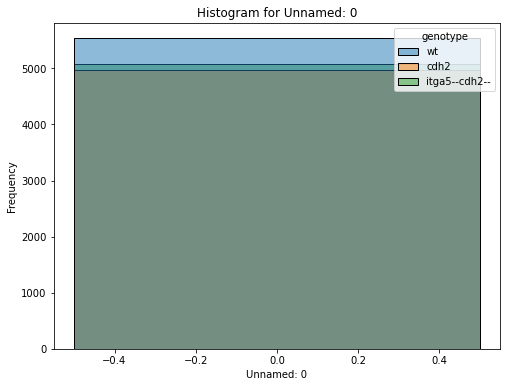

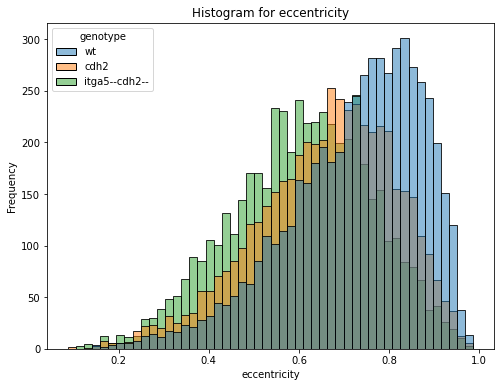

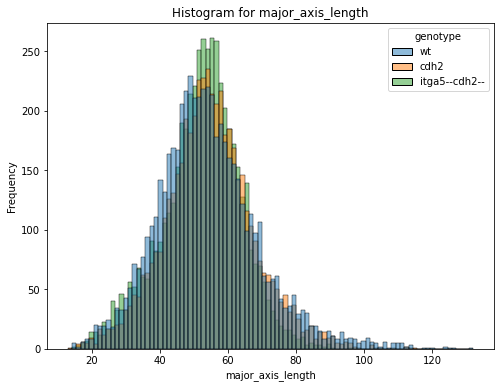

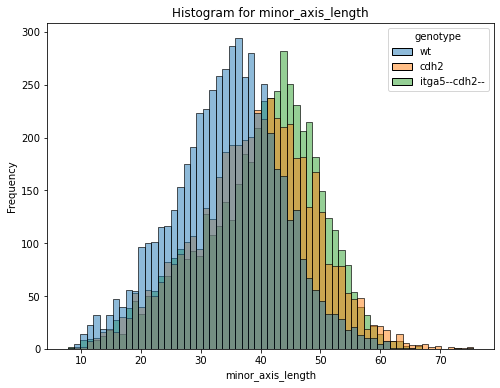

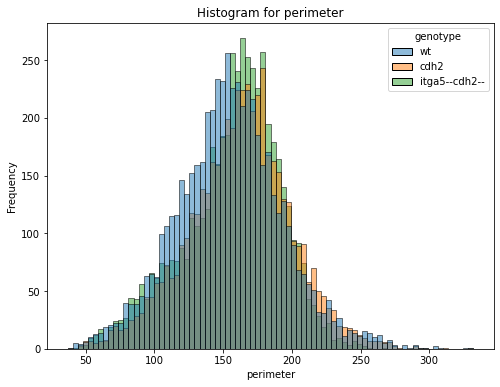

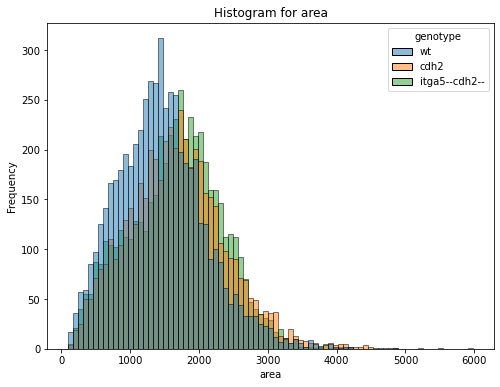

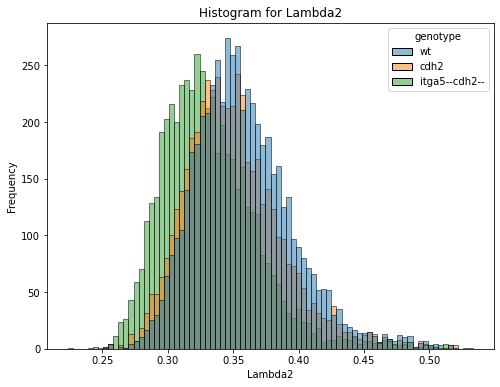

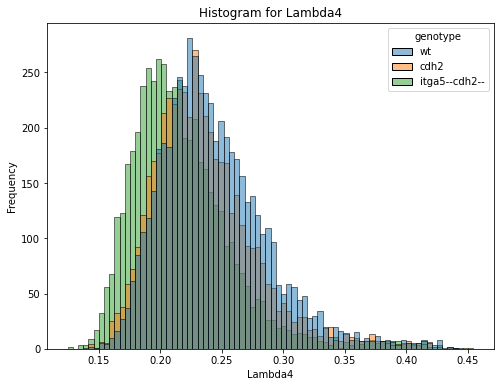

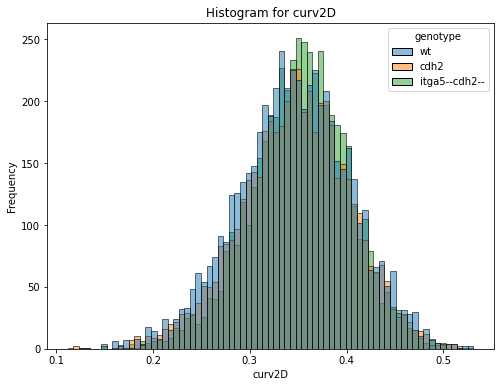

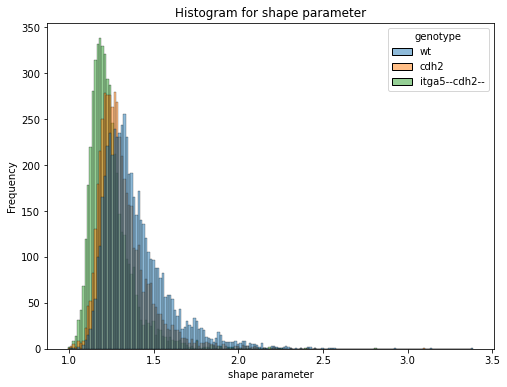

In [5]:
# EDA - let's look at distributions, outliers, and correlations in the features

# Looking or univariate information:
#  For numerical data, plot histograms
for column in df: 
    if np.issubdtype(df[column], np.number): 
        plt.figure(figsize=(8, 6))
        sns.histplot(df, x=column, hue='genotype')
        plt.title(f'Histogram for {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
    

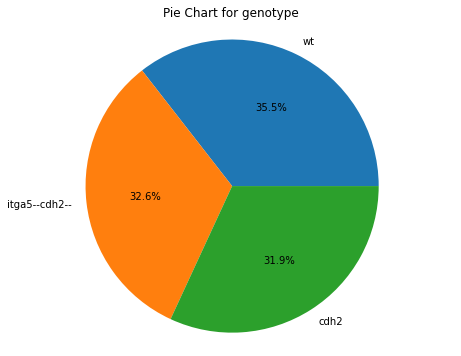

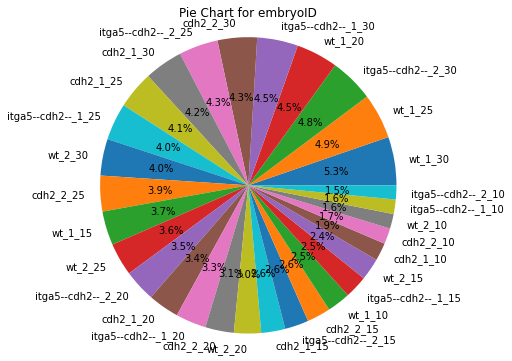

In [6]:
#. For categorical data, make a pie chart
categorical_columns = df.select_dtypes(include=['object', 'category'])
for column in categorical_columns.columns:
    category_counts = categorical_columns[column].value_counts()
    plt.figure(figsize=(8, 6))
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
    plt.title(f'Pie Chart for {column}')
    plt.axis('equal')
    plt.savefig('pieChart'+column+'.jpg')
    plt.show()

In [7]:
# discard low quality data
df = df[(df["area"] > 500) & (df["area"] < 3000)] 
df = df.drop(columns="Unnamed: 0")
genotype_counts = df['genotype'].value_counts()
print(genotype_counts)

wt               5109
itga5--cdh2--    4729
cdh2             4576
Name: genotype, dtype: int64


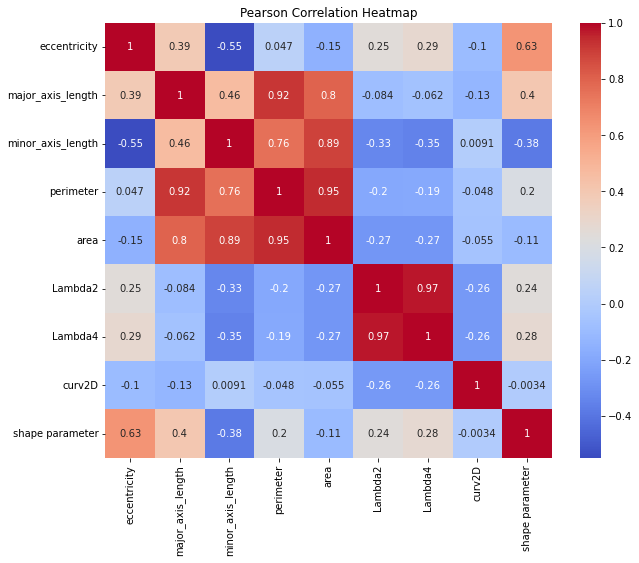

In [8]:
# Calculate and display Pearson correlation coefficients
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Pearson Correlation Heatmap")
plt.show()

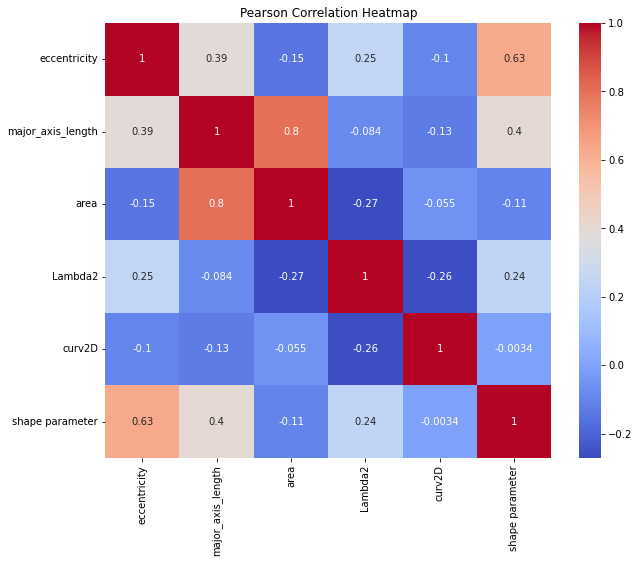

In [9]:
# Feature selection - area and perimeter track very closely, and major_axis and perimeter track very closely. 
# dropping perimeter.
df = df.drop(columns=["perimeter", "minor_axis_length", "Lambda4"])
# Calculate and display Pearson correlation coefficients
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Pearson Correlation Heatmap")
plt.show()

In [10]:
X, y = df.drop(["genotype", "embryoID"], axis=1), df.genotype
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on your class labels and transform them to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

class_mapping = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))

#weight infrequent classes more heavily
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y), y = y)
class_weights = dict(zip(np.unique(y), class_weights))


In [41]:
def showAccuracyMetrics(y_test, y_pred, y_prob, classes_of_interest):
    #y_test is the target label
    #y_pred is the predicted target label
    #y_prob is the predicted probability, which is transformed into y_pred given a threshold value
    
    # show accuracy table
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    print(report)

    # binarize labels to index them for ROC
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_test.shape  # (n_samples, n_classes)


    for class_of_interest in classes_of_interest:
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        # the RocCurveDisplay takes y_prob, which are the predicted probabilities of the classes
        #. and the true y_values. It then varies the threshold from 0 to 1, 
        #. for which a value is predicted positive if above the threshold.
        #. Then, we keep track of whether the value is a true positive or a false positive, and 
        #.  plot the true positive rate and false positive rate parameterized by the threshold.
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_prob[:, class_id],
            name=f"{class_of_interest} vs rest",
            color="darkorange",
        )
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs rest")
        plt.legend()
        plt.show()

/Users/AndrewTon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/Users/AndrewTon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/Users/AndrewTon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/Users/AndrewTon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/Users/AndrewTon/anaconda3/lib/p

LogisticRegression(C=0.01,
                   class_weight={'cdh2': 1.0499708624708626,
                                 'itga5--cdh2--': 1.016000563896525,
                                 'wt': 0.9404319175311542},
                   penalty='none')
Accuracy: 0.50
               precision    recall  f1-score   support

         cdh2       0.42      0.29      0.34       940
itga5--cdh2--       0.53      0.66      0.59       956
           wt       0.52      0.55      0.54       987

     accuracy                           0.50      2883
    macro avg       0.49      0.50      0.49      2883
 weighted avg       0.49      0.50      0.49      2883



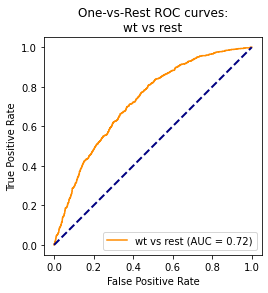

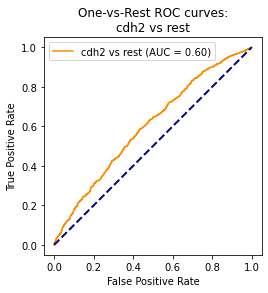

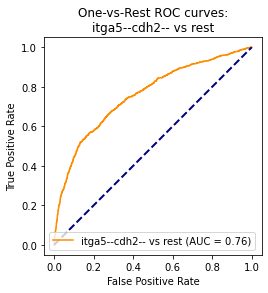

[[ 0.01983546 -0.29976429  0.38711363  0.19202483 -0.02324893  0.23327761]
 [-0.00081114 -0.10002986  0.14561272 -0.37219632  0.01687982 -0.58234941]
 [-0.01902432  0.39979415 -0.53272635  0.1801715   0.00636911  0.3490718 ]]


In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

# Logistic Regression
#penalty='l2', C=1.0, class_weight={}
logreg = LogisticRegression(class_weight=class_weights)

# since we are using a regularization penalty, we need to standardize. 
# standardize below!   

parameters = {
    'penalty':('l2', 'none'),
    'C':(0.01, 0.1, 1, 10)
}

X_train_std = (X_train - X_train.mean())/X_train.std()
X_test_std = (X_test - X_test.mean())/X_test.std()

clf = GridSearchCV(logreg, parameters)
clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)

# Calculate ROC-AUC score and plot ROC curve
y_prob = clf.predict_proba(X_test_std)

print(clf.best_estimator_)

classes_of_interest = ["wt", "cdh2", "itga5--cdh2--"]

showAccuracyMetrics(y_test, y_pred, y_prob, classes_of_interest)

In [73]:
# show coefficients of the best logistic regression from grid search
lr_coeffs = clf.best_estimator_.coef_
exp_coeffs = np.exp(lr_coeffs)
print(np.shape(lr_coeffs))
print(X_train.columns)
#print(lr_coeffs)
print(exp_coeffs)
# to interpret the exponentiated coefficients, one unit increase in the
#. predictor corresponds to multiplying the odds by the exponential of the coefficient

# Since we've trained our model on standardized data, a unit increase corresponds to one standard deviation increase.
#  We can see clearly that eccentricity and curv2D have low explanatory power. 
#.  Major_axis_length, area, lambda2 and shape parameter have much more explanatory power.


(3, 6)
Index(['eccentricity', 'major_axis_length', 'area', 'Lambda2', 'curv2D',
       'shape parameter'],
      dtype='object')
[[1.02003349 0.74099286 1.47272383 1.2117006  0.97701924 1.26273198]
 [0.99918919 0.9048104  1.15674811 0.68921892 1.01702309 0.55858448]
 [0.9811555  1.49151763 0.58700241 1.1974227  1.00638944 1.41775098]]


         class         Categories    Values
0           wt       eccentricity  1.020033
1         cdh2       eccentricity  0.999189
2   cdh2/itga5       eccentricity  0.981156
3           wt  major_axis_length  0.740993
4         cdh2  major_axis_length  0.904810
5   cdh2/itga5  major_axis_length  1.491518
6           wt               area  1.472724
7         cdh2               area  1.156748
8   cdh2/itga5               area  0.587002
9           wt            Lambda2  1.211701
10        cdh2            Lambda2  0.689219
11  cdh2/itga5            Lambda2  1.197423
12          wt             curv2D  0.977019
13        cdh2             curv2D  1.017023
14  cdh2/itga5             curv2D  1.006389
15          wt    shape parameter  1.262732
16        cdh2    shape parameter  0.558584
17  cdh2/itga5    shape parameter  1.417751


<AxesSubplot:xlabel='Categories', ylabel='Values'>

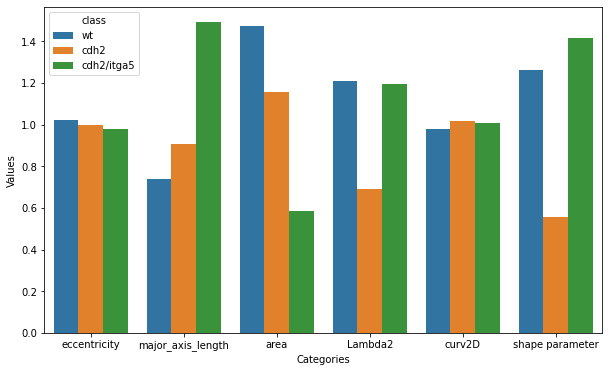

In [84]:
# To visualize this, plot e^beta_i vs predictor label, for each hue.
plt.figure(figsize=(10, 6))
coeff_df = pd.DataFrame(exp_coeffs, columns=X_train.columns)
coeff_df["class"] = coeff_df.index
coeff_df["class"] = coeff_df["class"].replace({0: 'wt', 1: 'cdh2', 2:'cdh2/itga5'})
melted_coeff = pd.melt(coeff_df, id_vars='class', var_name='Categories', value_name='Values')
print(melted_coeff)
sns.barplot(data=melted_coeff, x='Categories', y='Values', hue='class', ci=None)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, ...)
Accuracy: 0.52
               precision    recall  f1-score   support

         cdh2       0.43      0.30      0.35       940
itga5--cdh2--       0.61      0.57      0.59       956
           wt       0.50      0.67      0.57       987

     accuracy                           0.52      2

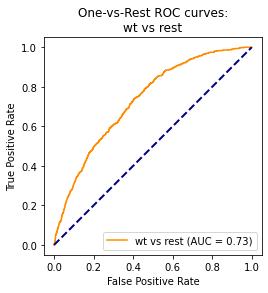

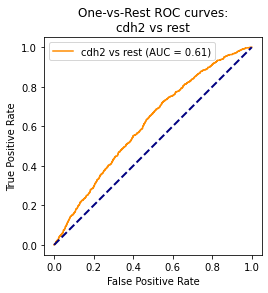

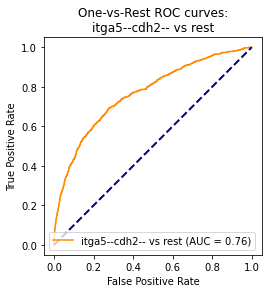

In [60]:
# Create and configure the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # for multiclass classification
    num_class=3,  # Number of classes 
    random_state=0,  # Set a random seed for reproducibility
)

parameters = {
    'n_estimators':(10,25,100)
}

# balance weights in the loss function to penalize missing on the smaller classes
w = [class_weights[key] for key in y_train]

clf = GridSearchCV(xgb_model, parameters)

# Fit the model to the training data
clf.fit(X_train, y_train_encoded, sample_weight=w)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

y_pred_decoded = [class_mapping[pred] for pred in y_pred]

print(clf.best_estimator_)

showAccuracyMetrics(y_test, y_pred_decoded, y_prob, classes_of_interest)

RandomForestClassifier(class_weight={'cdh2': 1.0499708624708626,
                                     'itga5--cdh2--': 1.016000563896525,
                                     'wt': 0.9404319175311542},
                       max_depth=5)
Accuracy: 0.52
               precision    recall  f1-score   support

         cdh2       0.44      0.30      0.35       940
itga5--cdh2--       0.62      0.57      0.59       956
           wt       0.51      0.70      0.59       987

     accuracy                           0.52      2883
    macro avg       0.52      0.52      0.51      2883
 weighted avg       0.52      0.52      0.51      2883



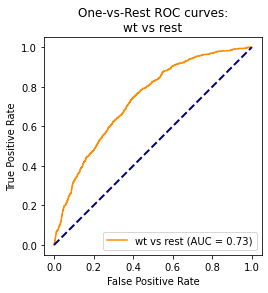

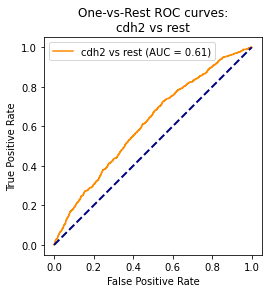

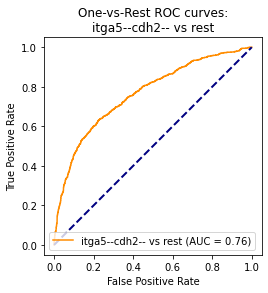

In [63]:
rfc = RandomForestClassifier(class_weight=class_weights)
parameters = {
    'n_estimators':(10, 50, 100),
    'max_depth':(5, 10, 25),
    'min_samples_split':(2,5,10)
}
clf = GridSearchCV(rfc, parameters)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Calculate ROC-AUC score and plot ROC curve
y_prob = clf.predict_proba(X_test)

classes_of_interest = ["wt", "cdh2", "itga5--cdh2--"]

print(clf.best_estimator_)

showAccuracyMetrics(y_test, y_pred, y_prob, classes_of_interest)